# **COMP30230**

# **Qirun** **Chen** - **Student** **No. 16212138**

# Multi layer perceptron 

In [0]:
"""
Multi Layer Perceptron - only built with a single hidden layer

An assignment of Connectionist Computing - UCD COMP30230 Module

- Support learning the XOR problem
- Support learning the Sin function
- Support identifying handwritten letters trained by the data set below
    Link => http://archive.ics.uci.edu/ml/datasets/Letter+Recognition
"""

__version__ = '0.1'
__author__ = 'Qirun Chen - Student No. 16212138'
__date__ = '27 Apr 2018'

import numpy as np


class MLP:
    def __init__(self, n_i, n_h, n_o, activation='sigmoid', max_epochs=5000,
                 learning_rate=0.1, verbose=2):
        """ Initialize the whole network
        :param n_i: The number of units in the input layer
        :param n_h: The number of units in the hidden layer
        :param n_o: The number of units in the output layer
        :param activation: The activation function for activating the weights and inputs
        :param max_epochs: The maximum iterations to training the MLP, to adjust weights
        :param learning_rate: Indicating how much the delta on weights would be accepted
        :param verbose: How much details should be printed during the training
        """

        self.n_i = n_i
        self.n_h = n_h
        self.n_o = n_o
        self.max_epochs = max_epochs
        self.learning_rate = learning_rate
        self.verbose = np.power(10, verbose-1)
        # Initialize the activation function and its derivative functions
        self.activation, self.d_activation = \
            self.__initialize_activation_func(activation)

        # Initialize the loss function
        self.__initialize_loss_func()

        # Initialize the units to hold activation results
        self.input = np.ones(self.n_i + 1)  # 1 for bias
        self.h = np.ones(self.n_h)
        self.o = np.ones(self.n_o)

        # Initialize the weights of the lower layer and the upper layer
        self.W1, self.W2 = self.__initialize_weights()

    def __initialize_activation_func(self, activation):
        """ Initialize the activation function and its derivative function
        :param activation: The symbol of activation, taking a string
        :return: The assigned activation function and its derivative
        """
        # Temporarily using tanh - a rescaled logistic sigmoid function
        return tanh, d_tanh

    def __initialize_loss_func(self):
        """ Initialize the loss function
        - when n_o > 1, classification should apply cross entropy
        - when n_o = 1, like a regression problem, should use squared error
        :return: None
        """
        if self.n_o > 1:
            self.loss_func = cross_entropy
        else:
            self.loss_func = squared_error

    def __initialize_weights(self):
        """ Randomly initialize weights between -1 and 1
                for the lower layer and the upper layer
        :return: The initialized weights
        """
        w1 = np.random.uniform(-0.2, 0.2, (self.input.size, self.h.size))
        w2 = np.random.uniform(-0.2, 0.2, (self.h.size, self.o.size))
        return w1, w2

    def __forwards(self, inputs):
        """ Propagate the inputs forward from the input layer
                to the output layer
        :param inputs: The training example
        :return: The output on output units
        """

        # In the input layer, the last one is 1 for bias
        self.input[:-1] = inputs
        # Activate the hidden layer
        self.h = self.activation(np.dot(self.input, self.W1))
        if self.n_o > 1:
            # Classification - using SoftMax
            self.o = softmax(np.dot(self.h, self.W2))
        else:
            # Regression
            self.o = self.activation(np.dot(self.h, self.W2))

        return self.o

    def __backwards(self, expected):
        """ The core training technique.
                Propagate the error signal back to each layer,
                and adjust the weights
        :param expected: The expected outputs for calculating the error
        :return: None
        """

        # The error on the output layer
        error = expected - self.o
        # Computing the delta activation of the output layer
        if self.n_o > 1:
            # Classification
            dz2 = error * d_softmax(self.o, softmax)
        else:
            # Regression
            dz2 = error * self.d_activation(self.o)
        # Computing the delta activation of the hidden layer
        dz1 = np.dot(dz2, self.W2.T) * self.d_activation(self.h)

        # Update the weights
        self.__update_weights(dz1, dz2)

    def __update_weights(self, dz1, dz2):
        """ Update weights on the lower layer and the upper layer
        :param dz1: The delta on the hidden layer
        :param dz2: The delta on the output layer
        :return: None
        """
        dw1 = np.dot(np.atleast_2d(self.input).T, np.atleast_2d(dz1))
        self.W1 += self.learning_rate * dw1
        dw2 = np.dot(np.atleast_2d(self.h).T, np.atleast_2d(dz2))
        self.W2 += self.learning_rate * dw2

    def fit(self, X, y):
        """ Training the MLP network by the training set
        Adjust the weights by iterate the training set max-epoch times
        :param X: The features of the training set
        :param y: The labels/Outputs of the training set
        :return: self
        """
        for e in range(1, self.max_epochs):
            cost = 0.
            for j, row in enumerate(X):
                # feed-forward the inputs to the output layer
                o = self.__forwards(row)
                # Accumulate the error of each example computed
                #   by the loss function to get the cost
                cost += self.loss_func(o, y[j])
                # Back-propagate the error signal computed
                #   according to the given expected output
                self.__backwards(y[j])

            # Print details during training
            if self.n_o > 1:
                # Classification
                # Predict the training set and print the current accuracy
                pre = self.predict(X)
                acc = 0.
                for k, _ in enumerate(y):
                    if pre[k] == np.argmax(y[k]):
                        acc += 1
                if e % self.verbose == 0:
                    print('epoch %d | error : %.3f | accuracy : %.3f' %
                          (e, cost/len(X), acc/len(X)))
            else:
                if e % self.verbose == 0:
                    # Regression - print the error
                    print('epoch %d | error : %.3f' % (e, cost/(len(X))))

        return self

    def predict(self, X):
        """ Predict on the test set
        :param X: The unseen features of the test set
        :return: The predicted output for each example in the test set
        """
        y = list()
        for j, row in enumerate(X):
            if self.n_o > 1:
                # Classification - using one hot encoding,
                #   so find the index of output units with the max output
                y.append(np.argmax(self.__forwards(row)))
            else:
                y.append(self.__forwards(row))
        return np.array(y)


# Definitions of sigmoid, derivatives, SoftMax, and loss functions
def tanh(x):
    """ The rescaled logistic sigmoid function
    :param x: The input needs to be activated
    :return: corresponding tanh value with the input x
    """
    return np.tanh(x)


def d_tanh(x):
    """ The derivative of the tanh activation function
    :param x: The input value
    :return: The derivative
    """
    return 1.0 - x**2


def softmax(x):
    """ Compute the SoftMax of vector x in a numerically stable way,
            since numpy's exp would lead to infinite (nan)
    :param x: In Classification, the inputs on the output units need to be activated
    :return: The probabilities on each output unit. The sum should be 1.
    """
    shiftx = x - np.max(x)
    exps = np.exp(shiftx)
    return exps / np.sum(exps)


def d_softmax(o, f):
    """ The derivative of SoftMax with respect to the output
    :param o: The output
    :param f: The activation function of the output layer - SoftMax in classification
    :return: The derivative
    """
    return f(o) * (1 - f(o))


def cross_entropy(o, y):
    """ Cross entropy loss function
    :param o: The output
    :param y: The expected output
    :return: The cross entropy - the loss
    """
    return np.sum(np.nan_to_num(-y * np.log(o) - (1-y) * np.log(1-o)))


def squared_error(o, y):
    """ Squared error loss function
    :param o: The output
    :param y: The expected output
    :return: The square error - the loss
    """
    return 0.5 * ((y-o) ** 2).sum()




## Test 1 - Learning XOR problem

 [0, 0] => 0
 
 [0, 1] => 1
 
 [1, 0] => 1
 
 [1, 1] => 0

In [58]:
"""
A test for Multi Layer Perceptron

An assignment of Connectionist Computing - UCD COMP30230 Module

- Test 1 to see if mlp learns the XOR problem
"""

__version__ = '0.1'
__author__ = 'Qirun Chen - Student No. 16212138'
__date__ = '27 Apr 2018'


# Initialize the XOR inputs
XOR_inputs = np.array([
    [0, 0, 0],
    [0, 1, 1],
    [1, 0, 1],
    [1, 1, 0]
])

# Split the inputs and outputs
x = XOR_inputs[:, :-1]
y = XOR_inputs[:, -1]

# Initialize the MLP network
mlp = MLP(2, 2, 1, max_epochs=2000, verbose=3)

# Training the MLP
mlp.fit(x, y)

# Predict the MLP on XOR inputs
prediction = mlp.predict(x)
print("==" * 20)
for i, l in enumerate(y):
    print('%s | expected : %.f | output : %.3f' % (str(x[i]), y[i], prediction[i]))



epoch 100 | error : 0.112
epoch 200 | error : 0.095
epoch 300 | error : 0.078
epoch 400 | error : 0.035
epoch 500 | error : 0.012
epoch 600 | error : 0.006
epoch 700 | error : 0.003
epoch 800 | error : 0.002
epoch 900 | error : 0.002
epoch 1000 | error : 0.001
epoch 1100 | error : 0.001
epoch 1200 | error : 0.001
epoch 1300 | error : 0.001
epoch 1400 | error : 0.001
epoch 1500 | error : 0.001
epoch 1600 | error : 0.001
epoch 1700 | error : 0.000
epoch 1800 | error : 0.000
epoch 1900 | error : 0.000
[0 0] | expected : 0 | output : 0.005
[0 1] | expected : 1 | output : 0.962
[1 0] | expected : 1 | output : 0.961
[1 1] | expected : 0 | output : 0.003


## Test 2 - Learning Sin function

### sin(x1-x2+x3-x4)

In [68]:
"""
A test for Multi Layer Perceptron

An assignment of Connectionist Computing - UCD COMP30230 Module

- Test 2 to see if mlp learns the Sin function
"""

__version__ = '0.1'
__author__ = 'Qirun Chen - Student No. 16212138'
__date__ = '27 Apr 2018'


# Initialize the MLP network
mlp = MLP(4, 10, 1, learning_rate=0.1, max_epochs=3000, verbose=3)

# Initialize the training set and test set
sample_num = 500
split_ratio = 0.8
train_num = int(sample_num * split_ratio)
test_num = sample_num - train_num

# Randomly initialize the inputs
X = np.random.uniform(-1, 1, (sample_num, 4))
# Compute the output according to the function sin(x1-x2+x3-x4)
y = list(map(lambda a: np.sin(a[0] - a[1] + a[2] - a[3]), X))
# Stack the output to the x values
ds = np.column_stack((X, y))

# Split the training set and test set
train = ds[:train_num]
test = ds[train_num:]

# Train the MLP network
mlp.fit(train[:, :-1], train[:, -1])


epoch 100 | error : 0.006
epoch 200 | error : 0.001
epoch 300 | error : 0.000
epoch 400 | error : 0.000
epoch 500 | error : 0.000
epoch 600 | error : 0.000
epoch 700 | error : 0.000
epoch 800 | error : 0.000
epoch 900 | error : 0.000
epoch 1000 | error : 0.000
epoch 1100 | error : 0.000
epoch 1200 | error : 0.000
epoch 1300 | error : 0.000
epoch 1400 | error : 0.000
epoch 1500 | error : 0.000
epoch 1600 | error : 0.000
epoch 1700 | error : 0.000
epoch 1800 | error : 0.000
epoch 1900 | error : 0.000
epoch 2000 | error : 0.000
epoch 2100 | error : 0.000
epoch 2200 | error : 0.000
epoch 2300 | error : 0.000
epoch 2400 | error : 0.000
epoch 2500 | error : 0.000
epoch 2600 | error : 0.000
epoch 2700 | error : 0.000
epoch 2800 | error : 0.000
epoch 2900 | error : 0.000


In [71]:
test_x = test[:, :-1]
test_y = test[:, -1]
# Predict on the test set
prediction = mlp.predict(test_x).flatten()

cost = 0.
for i, l in enumerate(test_x):
    cost += 0.5 * (test_y[i] - prediction[i]) ** 2
    print('%s | expected : %.f | output : %.3f' % 
          (str(l), test_y[i], prediction[i]))
print('==' * 20)
print('error on test set : %.5f' % (cost/len(test_x)))

[ 0.21052972  0.02015795  0.76271994 -0.45459273] | expected : 1 | output : 0.968
[-0.53144349 -0.03693457 -0.32118328 -0.98627899] | expected : 0 | output : 0.183
[-0.15788841  0.99115722 -0.66410057  0.22267419] | expected : -1 | output : -0.910
[ 0.90034523  0.49676132  0.39518066 -0.28629993] | expected : 1 | output : 0.894
[-0.8190109  -0.66919025 -0.2892418  -0.91594012] | expected : 0 | output : 0.444
[ 0.21667442 -0.09182284 -0.08227725 -0.43948194] | expected : 1 | output : 0.605
[ 0.59136831  0.36976902 -0.06531821 -0.50908552] | expected : 1 | output : 0.604
[-0.71851288  0.17740553  0.9249166  -0.83790149] | expected : 1 | output : 0.766
[ 0.51128773  0.5391894   0.35820463 -0.24778348] | expected : 1 | output : 0.537
[ 0.12768396 -0.50392547 -0.754824    0.83719861] | expected : -1 | output : -0.827
[-0.73209477  0.01689286  0.96435228 -0.84309403] | expected : 1 | output : 0.887
[-0.96506678 -0.81170764 -0.19286978 -0.41397669] | expected : 0 | output : 0.073
[ 0.74254604

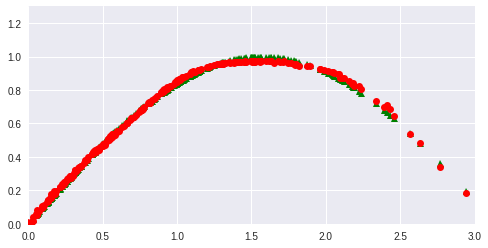

In [70]:
import matplotlib.pyplot as plt

# Compute the x value for the sin function for plotting
x = list(map(lambda a: a[0] - a[1] + a[2] - a[3], X))
output_y = mlp.predict(X)
# Indicate the figure size
plt.figure(figsize=(8, 4))
# Draw the real function and the MLP prediction approximated function
plt.plot(x, y, 'g^', x, output_y, 'ro')
# X axis [0, 3] | Y axis [0, 1.3]
plt.axis([0, 3, 0, 1.3])
plt.show()


## Exceptional Test - Letter Recognition

In [6]:
import warnings
warnings.filterwarnings('ignore')

import csv

def to_character(n):
    """ Map an integer to the character according to ASCII table
    :param n: The int number in ASCII
    :return: The character in ASCII
    """
    # The starting number of character 'A' in ASCII table
    char_delta = ord('A')
    return chr(int(n) + char_delta)


dataset = list()
# Read data from csv
with open('./letter-recognition.csv', newline='') as data_file:
    reader = csv.reader(data_file, delimiter=',')
    for row in reader:
        # Map the character to the integer number
        row[0] = ord(row[0]) - ord('A')
        dataset.append(row)

# Define a ratio to split the training test and test set
training_split = int(len(dataset) * 0.8)
# Split the training set
training_set = np.array(dataset[:training_split], dtype=np.int)
X = training_set[:, 1:]
y = training_set[:, 0]

# Define the number of output labels
num_labels = 26

# One hot encode y labels
categorical_y = np.zeros((len(y), num_labels))
for i, l in enumerate(y):
    categorical_y[i][l] = 1

# Normalize the features - Important!!!
X = X/15

# find a proper configuration
mlp = MLP(16, 30, 26, learning_rate=0.1, max_epochs=1300, verbose=3)
mlp.fit(X, categorical_y)

epoch 100 | error : 0.720 | accuracy : 0.862
epoch 200 | error : 0.680 | accuracy : 0.868
epoch 300 | error : 0.684 | accuracy : 0.869
epoch 400 | error : 0.707 | accuracy : 0.870
epoch 500 | error : 0.715 | accuracy : 0.862
epoch 600 | error : 0.733 | accuracy : 0.855
epoch 700 | error : 0.730 | accuracy : 0.849
epoch 800 | error : 0.743 | accuracy : 0.841
epoch 900 | error : 0.755 | accuracy : 0.846
epoch 1000 | error : 0.742 | accuracy : 0.848
epoch 1100 | error : 0.785 | accuracy : 0.851
epoch 1200 | error : 0.784 | accuracy : 0.842


In [23]:
# Split the inputs and outputs of the test set
test_set = np.array(dataset[training_split:], dtype=np.int)
test_x = test_set[:, 1:]
# Normalization - Important!!!
test_x = test_x / 15
test_y = test_set[:, 0]
# Predict on the normalized test set
prediction = mlp.predict(test_x)

# Print prediction details
# Initialize the confusion dictionary
confusion_dict = {to_character(i): 0 for i in range(26)}
letter_num_dict = {to_character(i): 0 for i in range(26)}
for i, _ in enumerate(test_y):

    letter_num_dict[to_character(test_y[i])] += 1
    # Print some predictions
    if i % 300 == 0:
        print('Expected: %s | Output: %s' % (to_character(test_y[i]), to_character(prediction[i])))
    if test_y[i] == prediction[i]:
        confusion_dict[to_character(prediction[i])] += 1
        

print('==' * 20)
# Calculate the accuracy
accuracy = sum(confusion_dict.values()) / len(test_y)
print('Test sample size: %d | Correctly predicted sample size: %d' % 
      (len(test_y), sum(confusion_dict.values())))
print('Accuracy: %.3f' % accuracy)

# Performance on each class
print('==' * 20)
for k,v in letter_num_dict.items():
    print('%s => Sample Number: %d | Correct Number: %d | Accuracy: %.3f' %
         (k, v, confusion_dict[k], confusion_dict[k]/v))

Expected: U | Output: M
Expected: M | Output: M
Expected: I | Output: I
Expected: S | Output: S
Expected: N | Output: N
Expected: N | Output: N
Expected: J | Output: J
Expected: R | Output: R
Expected: L | Output: L
Expected: M | Output: M
Expected: O | Output: O
Expected: H | Output: M
Expected: P | Output: F
Expected: J | Output: X
Test sample size: 4000 | Correctly predicted sample size: 3210
Accuracy: 0.802
A => Sample Number: 156 | Correct Number: 132 | Accuracy: 0.846
B => Sample Number: 136 | Correct Number: 114 | Accuracy: 0.838
C => Sample Number: 142 | Correct Number: 108 | Accuracy: 0.761
D => Sample Number: 167 | Correct Number: 146 | Accuracy: 0.874
E => Sample Number: 152 | Correct Number: 115 | Accuracy: 0.757
F => Sample Number: 153 | Correct Number: 119 | Accuracy: 0.778
G => Sample Number: 164 | Correct Number: 127 | Accuracy: 0.774
H => Sample Number: 151 | Correct Number: 75 | Accuracy: 0.497
I => Sample Number: 165 | Correct Number: 142 | Accuracy: 0.861
J => Sampl